In [1]:
# importing all the neccessary dependencies 
# importing the BEST and WORST learning classifiers with reference to the first Assignment:
# 1. a random forest (RF) learner - 98.41%
# 2. a decision tree classifier - 95.76%
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
# Dependecy to apply SHAP
import shap
import matplotlib.pyplot as plt

### A function to implement and compute "SHAP" values with refernce to the model and test set

In [11]:
def compute_shap_values(model, test_data, model_name, dataset_name, sample_index=0):
    if isinstance(model, (RandomForestClassifier, DecisionTreeClassifier)):
        explainer = shap.TreeExplainer(model)  # Use TreeExplainer for tree-based models
    else:
        explainer = shap.Explainer(model, test_data)  # General SHAP Explainer for other models
    
    X = test_data
        
    test_data = test_data.values if isinstance(test_data, pd.DataFrame) else test_data

    # Calculate SHAP values with correct indexing
    shap_values = explainer.shap_values(test_data) if isinstance(model, (RandomForestClassifier, DecisionTreeClassifier)) else explainer(test_data)
    
    # Plot SHAP summary for overall feature impact
    print(f"\nSHAP Summary Plot for Model {model_name} on Dataset {dataset_name}")
    shap.summary_plot(shap_values, test_data)
    
    # Determine the class index for the dependence plot (modify as needed)
    class_index = 1  # Select which class to visualize; adjust based on your needs
    shap_values_selected = shap_values[class_index] if isinstance(shap_values, list) else shap_values

    # Dependence Plot for a specific feature (e.g., 'feature_1')
    features = X.columns.to_list()
    print(f"\nSHAP Dependence Plot on Model {model_name} with Dataset {dataset_name}")
    for i in range(len(features) - 1):
        print(f"\nSHAP Dependence Plot for '{features[i]}' on Model {model_name} with Dataset {dataset_name}")
        shap.dependence_plot(features[i], shap_values_selected, X)
        
    # Interaction Plot for specified primary and interaction features
    # Considering a primary feature as age and plot it's interaction with other features
    primary_feature = features[0]
    for i in range(1, len(features) - 1):
        primary_feature = features[0]
        interaction_feature = features[i]
        print(f"\nSHAP Interaction Plot for '{features[0]}' with interaction on '{features[i]}'")
        shap.dependence_plot(primary_feature, shap_values_selected, X, interaction_index=interaction_feature)
    

    # Force Plot for a single prediction
    print(f"\nSHAP Force Plot for a single prediction in Model {model_name}")
    shap.initjs()  # Initialize JavaScript for visualizations
    
    # Check if shap_values is a list (multi-class case) or an array (binary case)
    if isinstance(shap_values, list):
        # Multi-class case: select the SHAP values for the class you’re interested in
        class_index = 1  # Modify this if you need a different class (e.g., 0, 1, or 2 for a 3-class model)
        shap.force_plot(explainer.expected_value[class_index], shap_values[class_index][sample_index], test_data[sample_index], matplotlib=True)
    else:
        # Binary classification case: directly use shap_values array
        shap.force_plot(explainer.expected_value, shap_values[sample_index], test_data[sample_index], matplotlib=True)

   # Waterfall Plot for a single prediction
    print(f"\nSHAP Waterfall Plot for a single prediction in Model {model_name}")
    
    # Check if shap_values is a list (multi-class case) or an array (binary case)
    if isinstance(shap_values, list):
        # Multi-class case: select the SHAP values for the class you’re interested in
        class_index = 1  # Modify this if you need a different class (e.g., 0, 1, or 2 for a 3-class model)
        # Create Explanation object with proper values and base value
        shap_value = shap.Explanation(values=shap_values[class_index][sample_index],
                                      base_values=explainer.expected_value[class_index],
                                      data=test_data[sample_index],
                                      feature_names=X.columns)
    else:
        # Binary classification case: directly use shap_values array
        shap_value = shap.Explanation(values=shap_values[sample_index],
                                      base_values=explainer.expected_value,
                                      data=test_data[sample_index],
                                      feature_names=X.columns)
    
    # Generate the waterfall plot
    shap.plots.waterfall(shap_value)
    
    # Decision Plot for selected samples (first 50 data points from the test set)
    print(f"\nSHAP Decision Plot for Model {model_name} on Dataset {dataset_name}")
    shap.decision_plot(explainer.expected_value[class_index], shap_values_selected[0:20], test_data[0:20], feature_names=features)

In [12]:
def changeTarget(data):
    for i in range(data.shape[0]):
        if(data.iloc[i, -1] == 'user'):
            data.iloc[i, -1] = 1
        elif(data.iloc[i, -1] == 'non-user'):
            data.iloc[i, -1] = 0
    return data

### Importing the dataset of the orignal choclate dataset with reference to assignment-1

In [13]:
df_choc_train = pd.read_csv("/Users/bhavneetsingh/Desktop/ML Assignment/choc_train.csv")
df_choc_train.drop(["Unnamed: 0"], inplace = True, axis = 1)
df_choc_test = pd.read_csv("/Users/bhavneetsingh/Desktop/ML Assignment/choc_test.csv")
df_choc_test.drop(["Unnamed: 0"], inplace = True, axis = 1)

In [14]:
df_choc_train.head()

,age,gender,education,country,ethnicity,nscore,escore,oscore,ascore,cscore,impuslive,ss,choc
0,-0.95197,-0.48246,-0.61113,-0.57009,-0.31685,-0.67825,0.00332,0.29338,1.81866,1.30612,-0.21712,-0.52593,user
1,-0.95197,-0.48246,-0.61113,-0.57009,-0.31685,0.82562,0.96248,-0.17779,-0.30172,-0.27607,1.29221,0.76540,user
2,0.49788,0.48246,-0.05921,0.96082,-0.31685,0.62967,0.47617,0.44585,-0.60633,-0.89891,1.29221,0.40148,user
3,1.09449,-0.48246,-0.05921,0.96082,-1.10702,-0.58016,0.32197,-0.45174,-0.15487,0.25953,-0.21712,-1.18084,user
4,-0.07854,-0.48246,0.45468,-0.57009,-0.31685,-0.67825,-0.80615,-0.45174,-1.47955,0.12331,-0.71126,-0.21575,user


In [15]:
# after changing the target of train dataset to numeric values
df_choc_train = changeTarget(df_choc_train)
df_choc_train 

,age,gender,education,country,ethnicity,nscore,escore,oscore,ascore,cscore,impuslive,ss,choc
0,-0.95197,-0.48246,-0.61113,-0.57009,-0.31685,-0.67825,0.00332,0.29338,1.81866,1.30612,-0.21712,-0.52593,1
1,-0.95197,-0.48246,-0.61113,-0.57009,-0.31685,0.82562,0.96248,-0.17779,-0.30172,-0.27607,1.29221,0.76540,1
2,0.49788,0.48246,-0.05921,0.96082,-0.31685,0.62967,0.47617,0.44585,-0.60633,-0.89891,1.29221,0.40148,1
3,1.09449,-0.48246,-0.05921,0.96082,-1.10702,-0.58016,0.32197,-0.45174,-0.15487,0.25953,-0.21712,-1.18084,1
4,-0.07854,-0.48246,0.45468,-0.57009,-0.31685,-0.67825,-0.80615,-0.45174,-1.47955,0.12331,-0.71126,-0.21575,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1503,1.09449,-0.48246,1.16365,-0.57009,-0.31685,-0.34799,0.32197,0.14143,-1.21213,0.25953,0.19268,0.40148,1
1504,-0.07854,0.48246,1.16365,-0.57009,-0.31685,0.31287,1.28610,-0.17779,-0.76096,-1.01450,0.19268,-0.52593,1
1505,-0.95197,0.48246,0.45468,0.96082,-0.31685,1.72012,-1.23177,-0.71727,-0.60633,0.12331,-1.37983,0.40148,1
1506,-0.95197,0.48246,0.45468,0.96082,-0.31685,1.02119,0.16767,-0.71727,0.28783,0.41594,-0.71126,-0.52593,1


In [16]:
df_choc_test.head()

,age,gender,education,country,ethnicity,nscore,escore,oscore,ascore,cscore,impuslive,ss,choc
0,-0.95197,0.48246,0.45468,0.96082,-0.31685,0.82562,-0.30033,0.29338,-0.01729,0.12331,0.19268,0.07987,user
1,-0.07854,-0.48246,0.45468,0.96082,-0.31685,0.13606,-0.30033,-0.97631,-1.34289,-0.00665,0.19268,-0.52593,user
2,0.49788,0.48246,-0.05921,0.96082,-0.31685,-0.24649,-0.57545,-0.17779,-0.30172,0.75830,0.88113,0.40148,user
3,1.09449,0.48246,-0.61113,0.96082,-0.31685,-0.24649,1.58487,-0.84732,1.28610,0.58489,-0.71126,-0.84637,user
4,1.09449,0.48246,-1.43719,0.24923,-0.31685,-0.34799,-0.69509,-1.55521,0.43852,0.58489,-2.55524,-2.07848,user


In [17]:
# after changing the target of test dataset to numeric values
df_choc_test = changeTarget(df_choc_test)
df_choc_test

,age,gender,education,country,ethnicity,nscore,escore,oscore,ascore,cscore,impuslive,ss,choc
0,-0.95197,0.48246,0.45468,0.96082,-0.31685,0.82562,-0.30033,0.29338,-0.01729,0.12331,0.19268,0.07987,1
1,-0.07854,-0.48246,0.45468,0.96082,-0.31685,0.13606,-0.30033,-0.97631,-1.34289,-0.00665,0.19268,-0.52593,1
2,0.49788,0.48246,-0.05921,0.96082,-0.31685,-0.24649,-0.57545,-0.17779,-0.30172,0.75830,0.88113,0.40148,1
3,1.09449,0.48246,-0.61113,0.96082,-0.31685,-0.24649,1.58487,-0.84732,1.28610,0.58489,-0.71126,-0.84637,1
4,1.09449,0.48246,-1.43719,0.24923,-0.31685,-0.34799,-0.69509,-1.55521,0.43852,0.58489,-2.55524,-2.07848,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
372,1.09449,0.48246,-0.61113,0.96082,-0.31685,-0.46725,-0.43999,-0.01928,0.13136,-0.40581,1.86203,-0.84637,1
373,0.49788,0.48246,-1.73790,-0.28519,-0.31685,-1.19430,-0.80615,0.14143,-0.60633,-0.00665,-1.37983,-0.84637,1
374,1.09449,-0.48246,-0.05921,0.96082,-0.31685,-1.32828,-0.30033,-0.17779,0.43852,-0.00665,-0.21712,-0.52593,1
375,-0.07854,-0.48246,0.45468,-0.57009,-0.31685,-0.79151,0.00332,0.14143,-1.07533,-0.27607,1.29221,1.22470,1


### Training the RandomForest classifier

In [18]:
X_train = df_choc_train.iloc[:,:-1].values
y_train = df_choc_train.iloc[:,-1:].values.ravel()
y_train = y_train.astype('int')
RandomForest = RandomForestClassifier(n_estimators=100,criterion="entropy",random_state=0)
RandomForest.fit(X_train,y_train)

RandomForestClassifier(criterion='entropy', random_state=0)

### Computing shap values with the best model (Random Forest) on chocolate test set 


SHAP Summary Plot for Model Random Forest on Dataset Chocolate Test Set


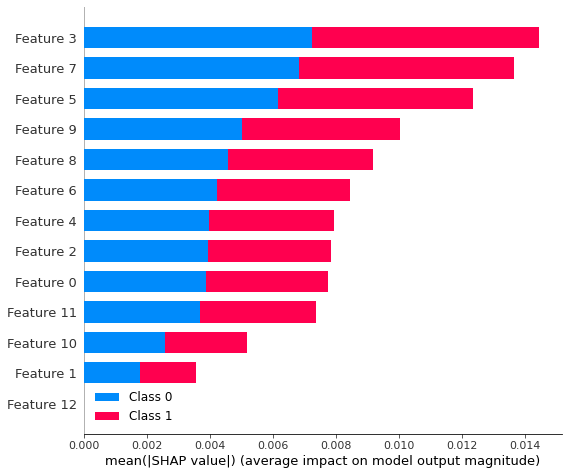


SHAP Dependence Plot on Model Random Forest with Dataset Chocolate Test Set

SHAP Dependence Plot for 'age' on Model Random Forest with Dataset Chocolate Test Set


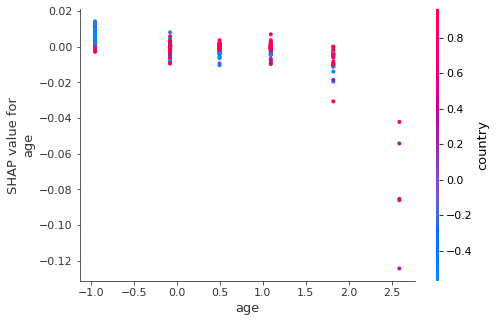


SHAP Dependence Plot for 'gender' on Model Random Forest with Dataset Chocolate Test Set


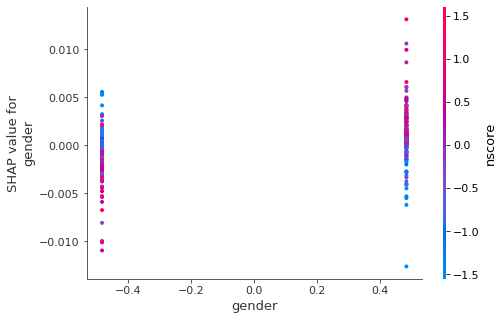


SHAP Dependence Plot for 'education' on Model Random Forest with Dataset Chocolate Test Set


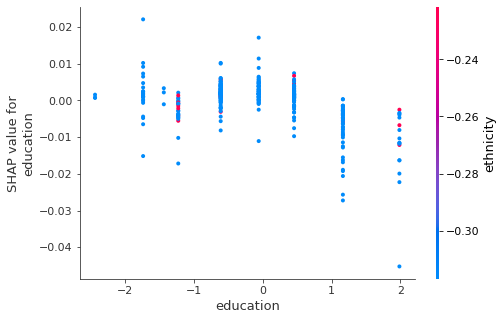


SHAP Dependence Plot for 'country' on Model Random Forest with Dataset Chocolate Test Set


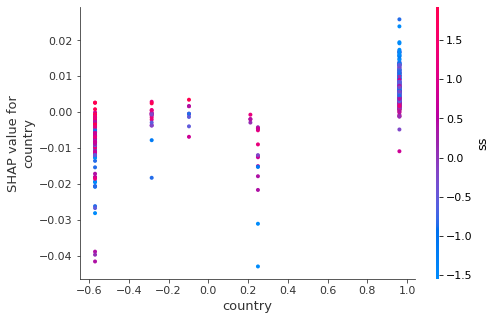


SHAP Dependence Plot for 'ethnicity' on Model Random Forest with Dataset Chocolate Test Set


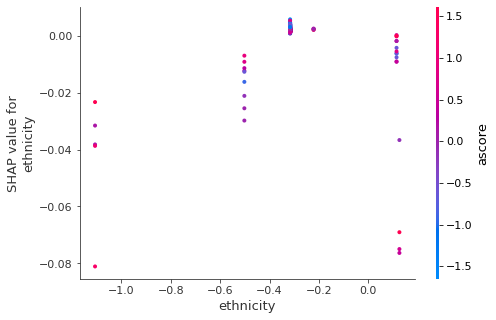


SHAP Dependence Plot for 'nscore' on Model Random Forest with Dataset Chocolate Test Set


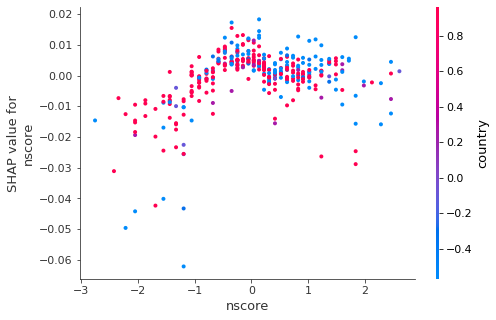


SHAP Dependence Plot for 'escore' on Model Random Forest with Dataset Chocolate Test Set


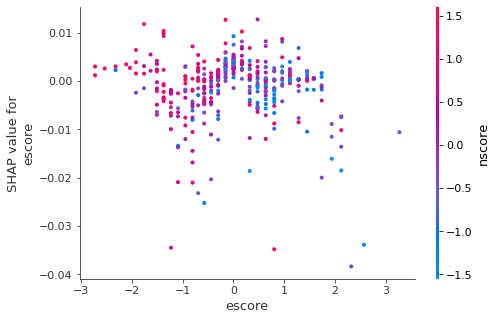


SHAP Dependence Plot for 'oscore' on Model Random Forest with Dataset Chocolate Test Set


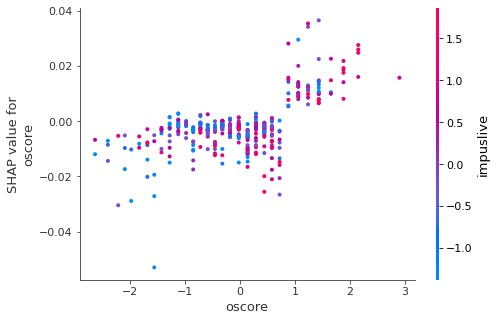


SHAP Dependence Plot for 'ascore' on Model Random Forest with Dataset Chocolate Test Set


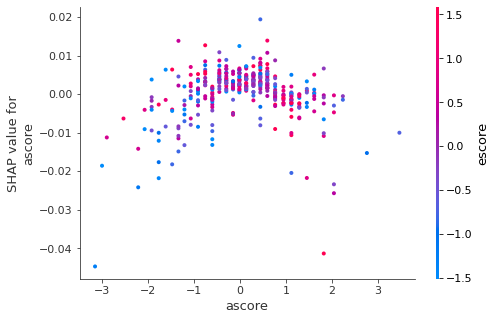


SHAP Dependence Plot for 'cscore' on Model Random Forest with Dataset Chocolate Test Set


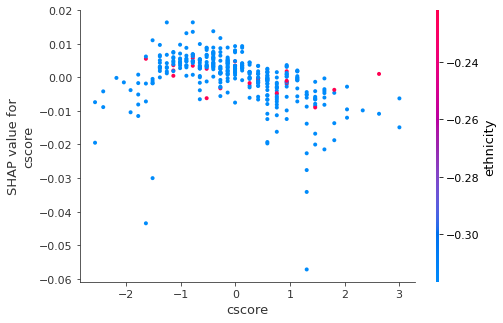


SHAP Dependence Plot for 'impuslive' on Model Random Forest with Dataset Chocolate Test Set


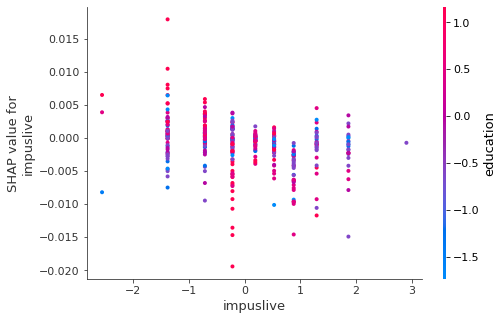


SHAP Dependence Plot for 'ss' on Model Random Forest with Dataset Chocolate Test Set


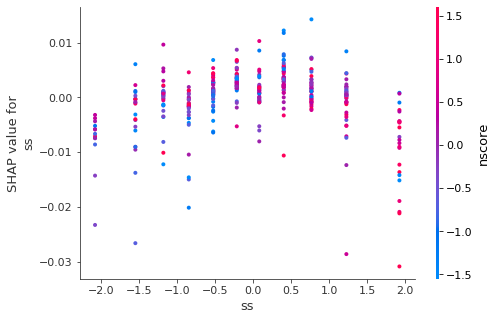


SHAP Interaction Plot for 'age' with interaction on 'gender'


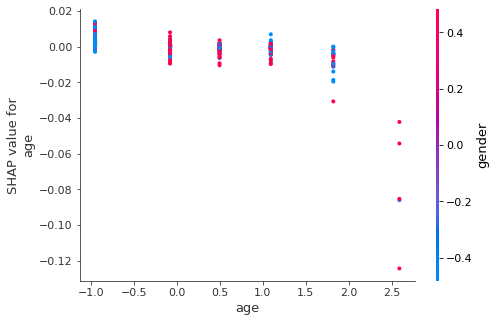


SHAP Interaction Plot for 'age' with interaction on 'education'


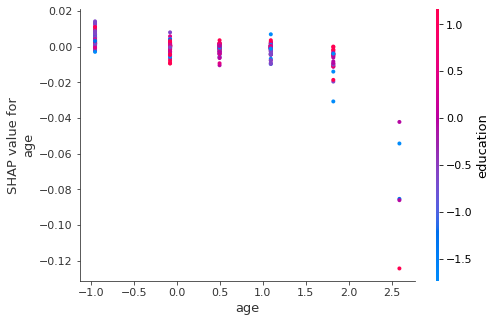


SHAP Interaction Plot for 'age' with interaction on 'country'


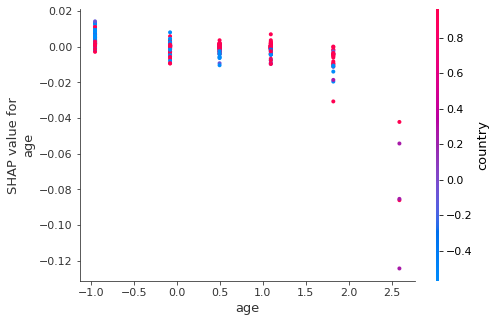


SHAP Interaction Plot for 'age' with interaction on 'ethnicity'


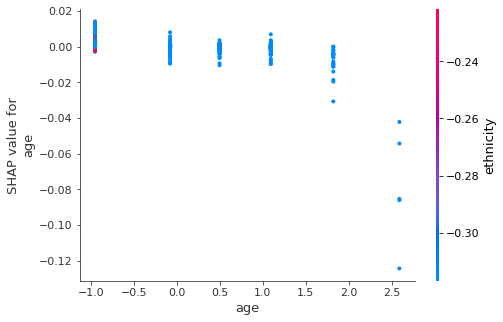


SHAP Interaction Plot for 'age' with interaction on 'nscore'


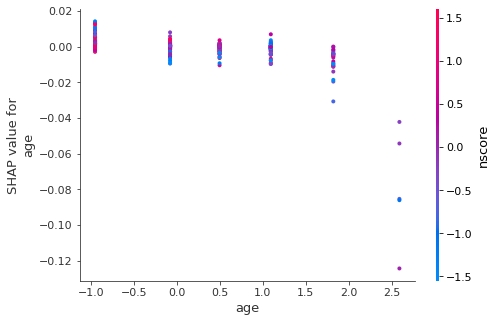


SHAP Interaction Plot for 'age' with interaction on 'escore'


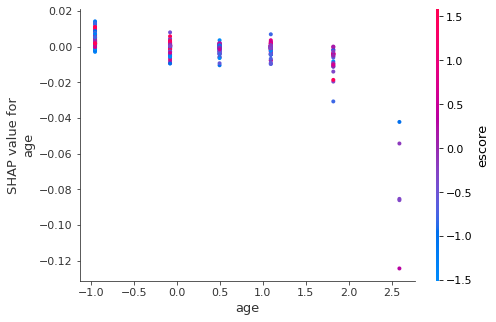


SHAP Interaction Plot for 'age' with interaction on 'oscore'


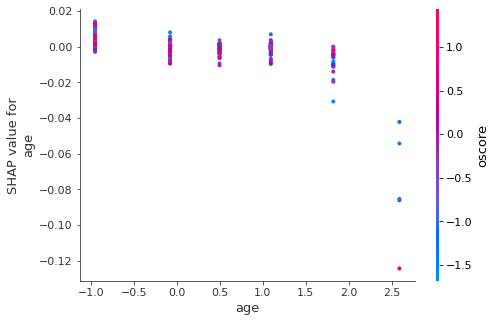


SHAP Interaction Plot for 'age' with interaction on 'ascore'


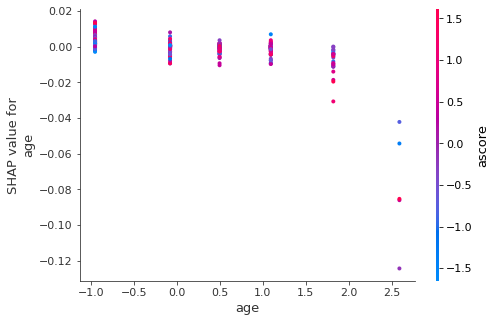


SHAP Interaction Plot for 'age' with interaction on 'cscore'


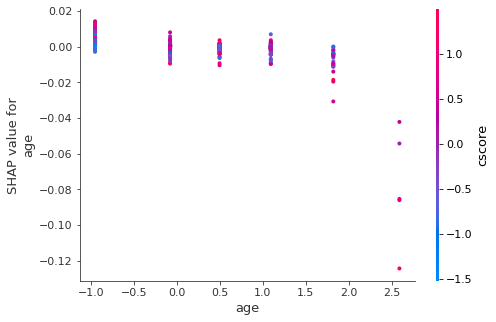


SHAP Interaction Plot for 'age' with interaction on 'impuslive'


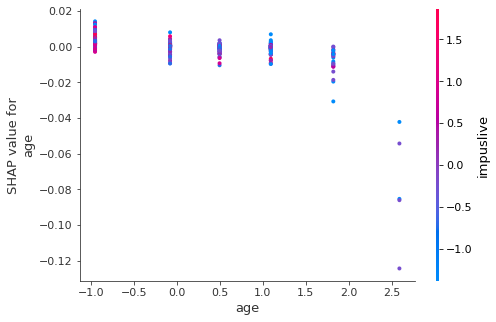


SHAP Interaction Plot for 'age' with interaction on 'ss'


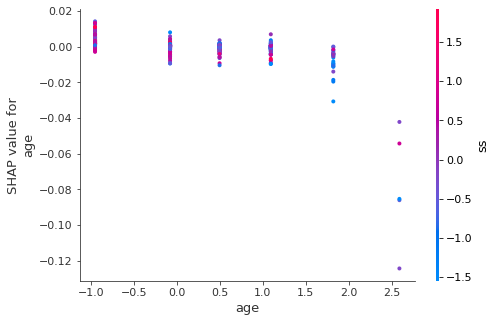


SHAP Force Plot for a single prediction in Model Random Forest


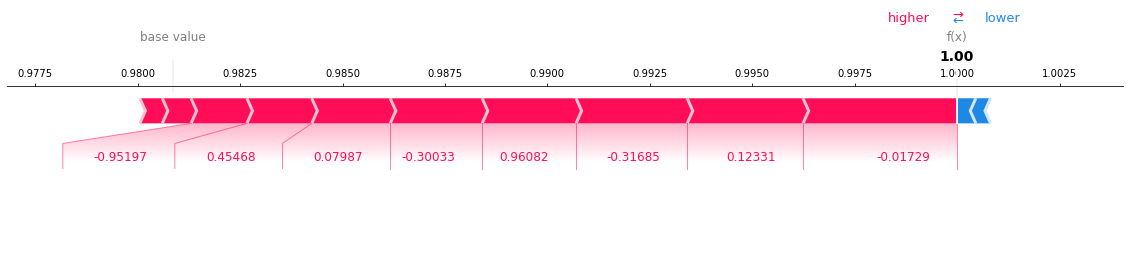


SHAP Waterfall Plot for a single prediction in Model Random Forest


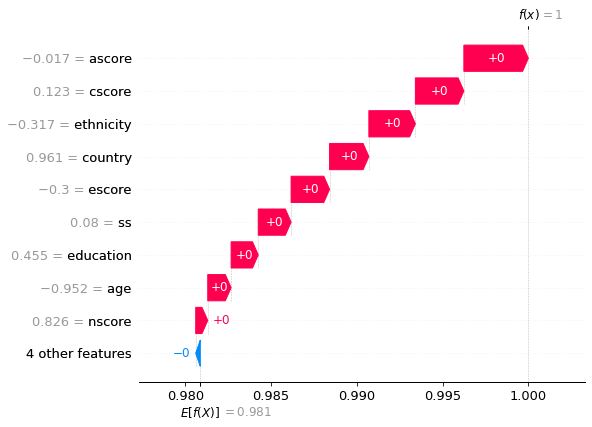


SHAP Decision Plot for Model Random Forest on Dataset Chocolate Test Set


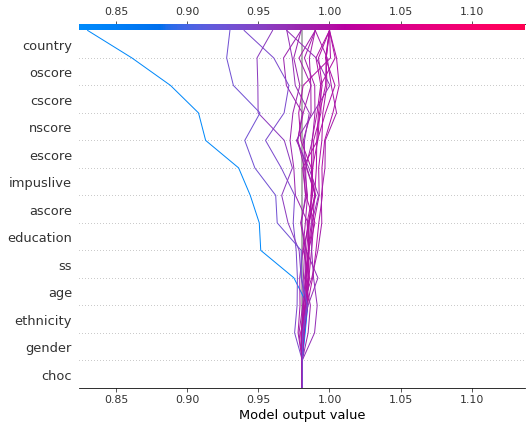

In [19]:
# SHAP values and respective Plots
compute_shap_values(RandomForest, df_choc_test, model_name="Random Forest", dataset_name="Chocolate Test Set")

### Training the DecisionTree classifier

In [11]:
decisionTree = DecisionTreeClassifier(criterion="entropy")
decisionTree.fit(X_train,y_train)

DecisionTreeClassifier(criterion='entropy')

### Computing shap values with the worst model (Decision Tree) on chocolate test set


SHAP Summary Plot for Model Decision Tree on Dataset Chocolate Test Set


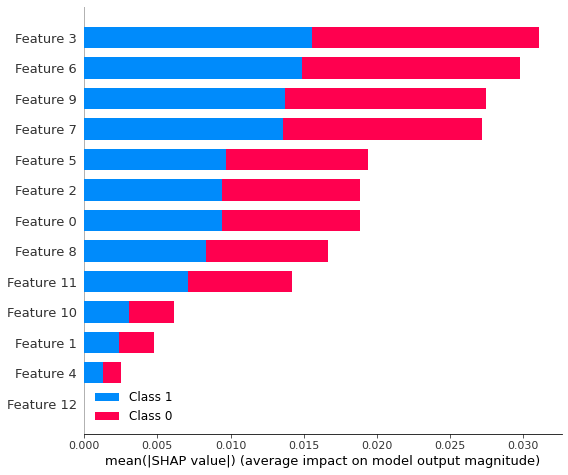


SHAP Dependence Plot on Model Decision Tree with Dataset Chocolate Test Set

SHAP Dependence Plot for 'age' on Model Decision Tree with Dataset Chocolate Test Set


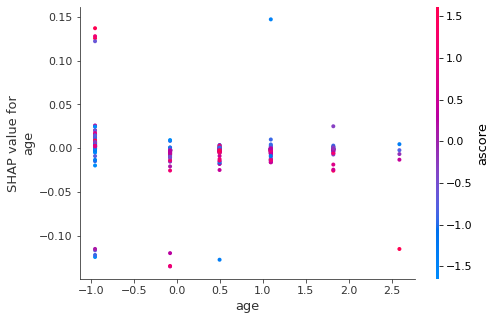


SHAP Dependence Plot for 'gender' on Model Decision Tree with Dataset Chocolate Test Set


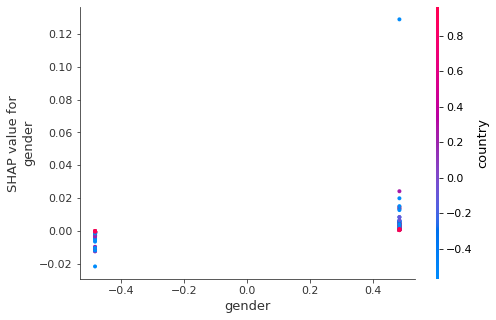


SHAP Dependence Plot for 'education' on Model Decision Tree with Dataset Chocolate Test Set


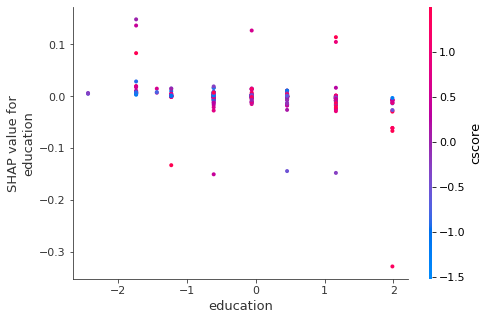


SHAP Dependence Plot for 'country' on Model Decision Tree with Dataset Chocolate Test Set


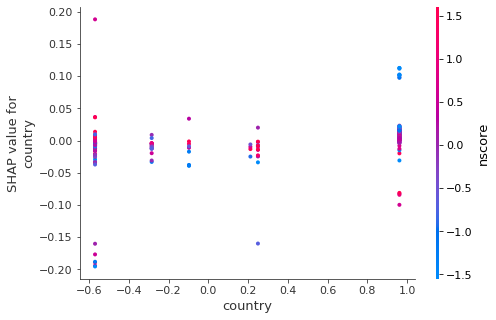


SHAP Dependence Plot for 'ethnicity' on Model Decision Tree with Dataset Chocolate Test Set


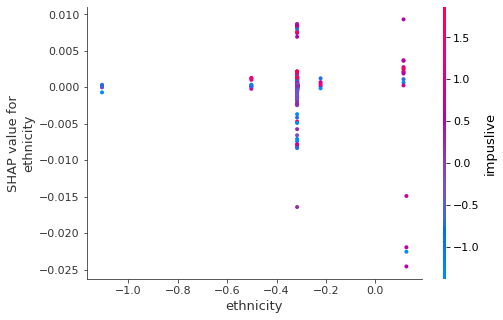


SHAP Dependence Plot for 'nscore' on Model Decision Tree with Dataset Chocolate Test Set


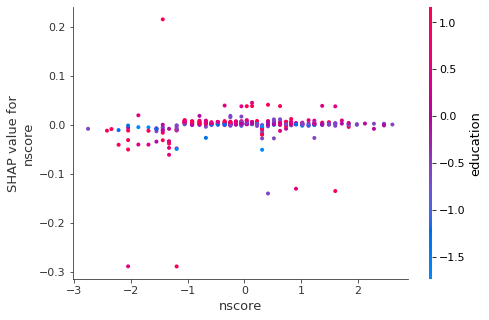


SHAP Dependence Plot for 'escore' on Model Decision Tree with Dataset Chocolate Test Set


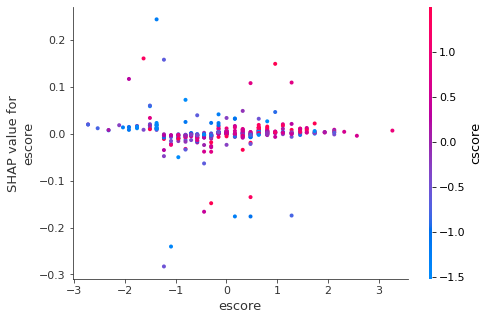


SHAP Dependence Plot for 'oscore' on Model Decision Tree with Dataset Chocolate Test Set


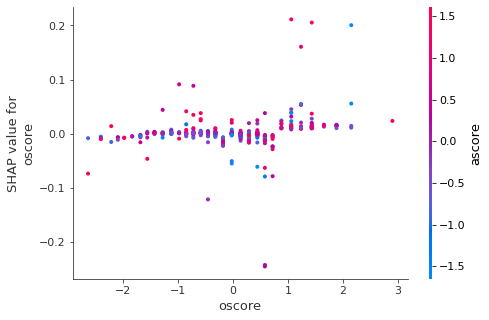


SHAP Dependence Plot for 'ascore' on Model Decision Tree with Dataset Chocolate Test Set


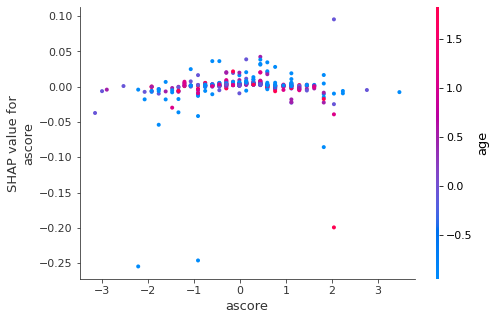


SHAP Dependence Plot for 'cscore' on Model Decision Tree with Dataset Chocolate Test Set


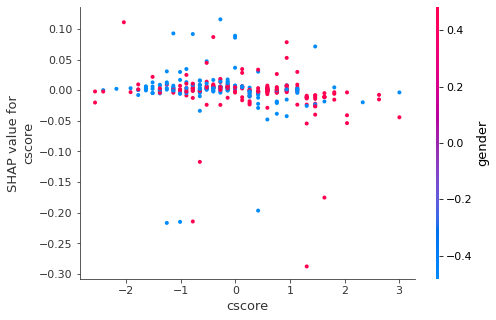


SHAP Dependence Plot for 'impuslive' on Model Decision Tree with Dataset Chocolate Test Set


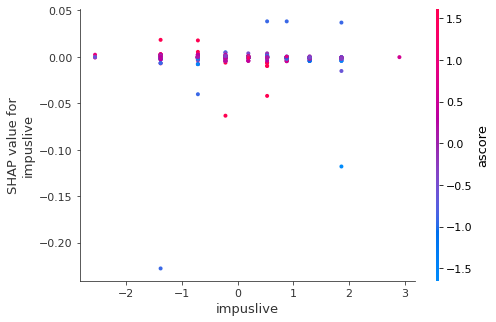


SHAP Dependence Plot for 'ss' on Model Decision Tree with Dataset Chocolate Test Set


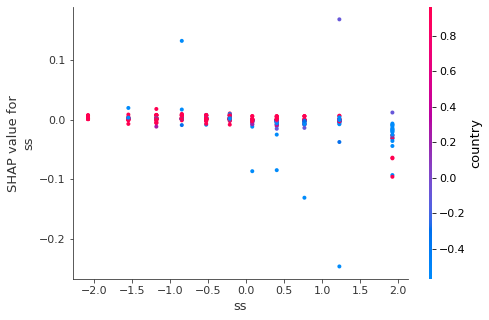


SHAP Interaction Plot for 'age' with interaction on 'gender'


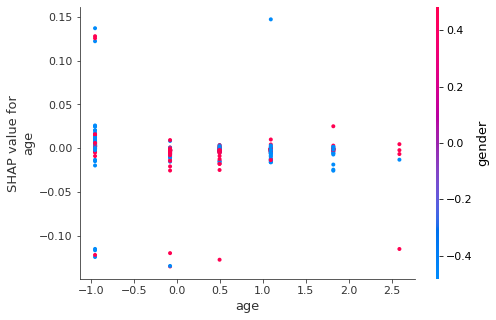


SHAP Interaction Plot for 'age' with interaction on 'education'


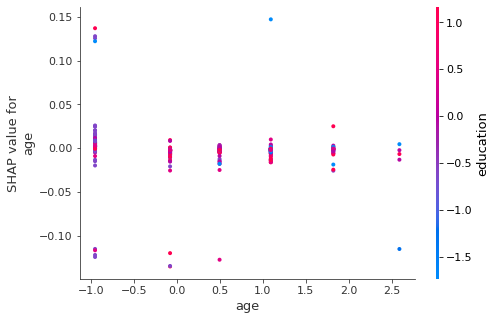


SHAP Interaction Plot for 'age' with interaction on 'country'


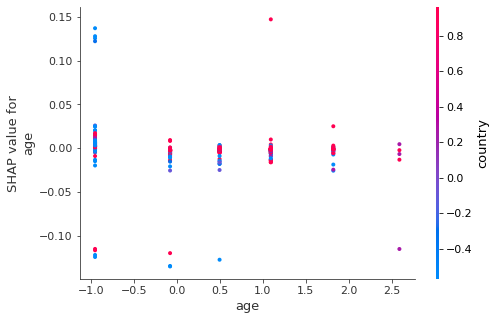


SHAP Interaction Plot for 'age' with interaction on 'ethnicity'


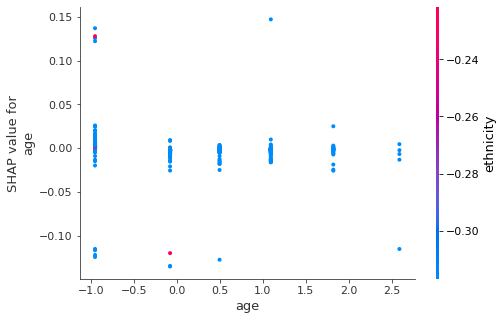


SHAP Interaction Plot for 'age' with interaction on 'nscore'


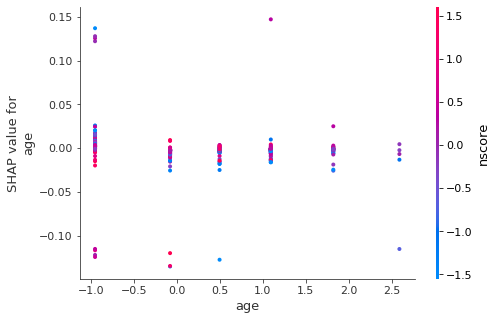


SHAP Interaction Plot for 'age' with interaction on 'escore'


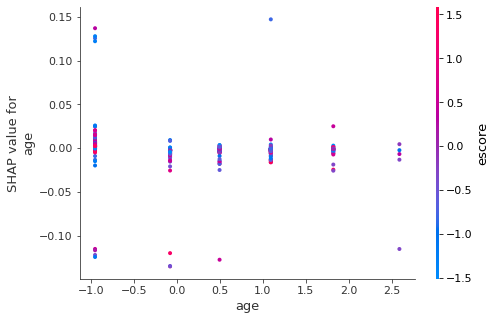


SHAP Interaction Plot for 'age' with interaction on 'oscore'


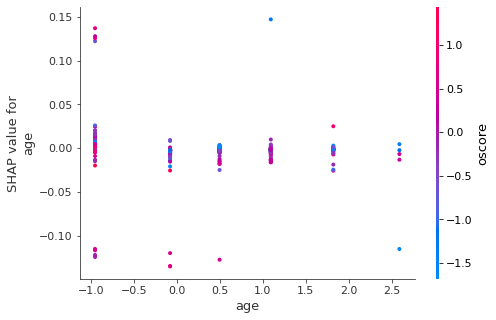


SHAP Interaction Plot for 'age' with interaction on 'ascore'


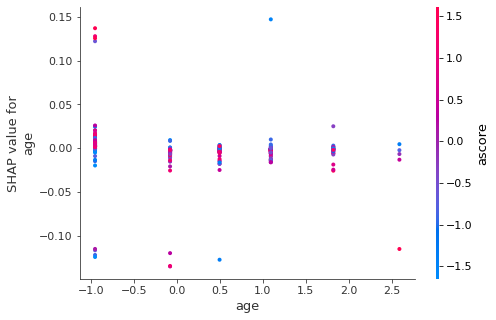


SHAP Interaction Plot for 'age' with interaction on 'cscore'


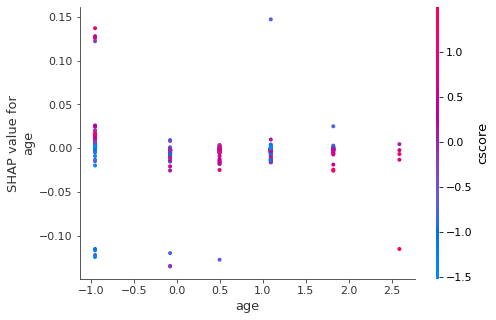


SHAP Interaction Plot for 'age' with interaction on 'impuslive'


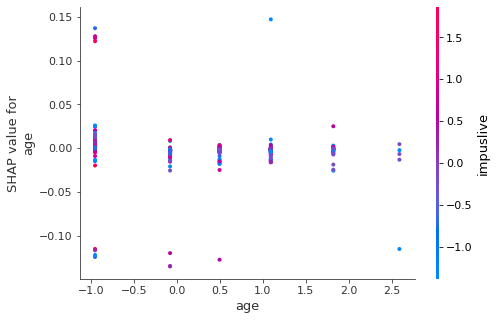


SHAP Interaction Plot for 'age' with interaction on 'ss'


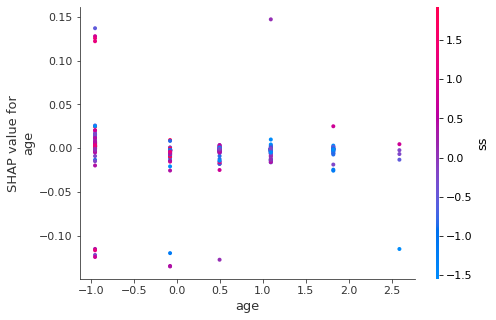


SHAP Force Plot for a single prediction in Model Decision Tree


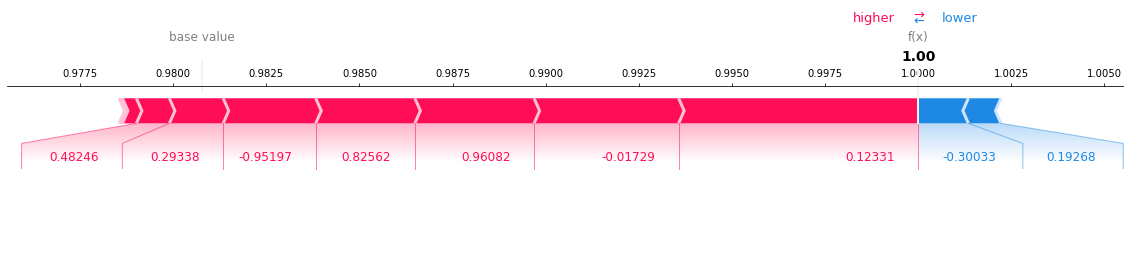


SHAP Waterfall Plot for a single prediction in Model Decision Tree


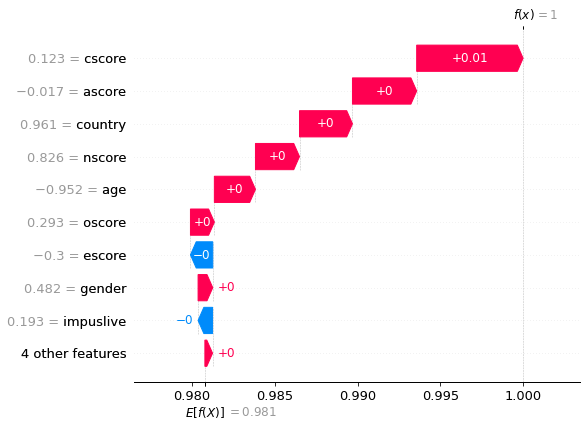


SHAP Decision Plot for Model Decision Tree on Dataset Chocolate Test Set


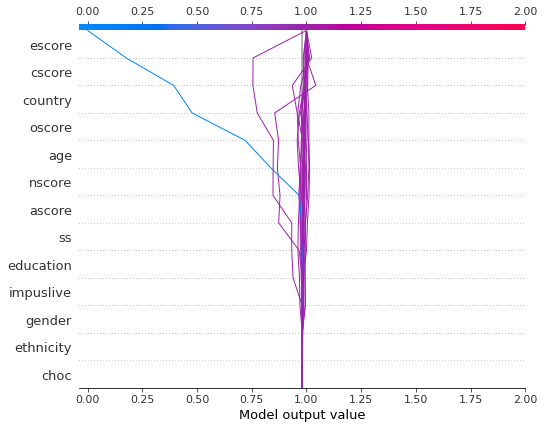

In [12]:
# SHAP values
compute_shap_values(decisionTree, df_choc_test, model_name="Decision Tree", dataset_name="Chocolate Test Set")